In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd, numpy as np
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from sklearn.model_selection import train_test_split

#from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, hamming_loss

%matplotlib inline
pd.set_option('display.max_colwidth', 600)

In [2]:
# Load book data for train and test sets
books_train = pd.read_csv('doc2vec_v1/books_train.csv')
books_test = pd.read_csv('doc2vec_v1/books_test.csv')
print(books_train.shape)
print(books_test.shape)

(50000, 10)
(10000, 10)


In [3]:
# Load lda trained topics for train and test sets
topics_train = pd.read_csv('doc2vec_v1/vector_train.csv')
topics_test = pd.read_csv('doc2vec_v1/vector_test.csv')
print(topics_train.shape)
print(topics_test.shape)

x_train = topics_train.copy()
x_test = topics_test.copy()

(50000, 2000)
(10000, 2000)


In [4]:
# split genres into genre lists for train and test data
books_train['genrelist'] = books_train['genres'].apply(lambda x: x[1:-1].split("', '"))
books_test['genrelist'] = books_test['genres'].apply(lambda x: x[1:-1].split("', '"))

In [5]:
# # Get entire list of genres from training set.
genres_list = [] 

# extract genres
for i in books_train['genrelist']: 
    for j in i:
        genres_list.append(j)

# remove 'fiction' as a genre since its a global genre for all books in this dataset.
# remove 'unfinshed' as a genre
genres_list = list(filter(lambda x: x != 'fiction', genres_list))
genres_list = list(filter(lambda x: x != 'unfinished', genres_list))
        
# Number of unique
print("Unique Genres: ",len(set(genres_list)))
unique_genre_list = list(set(genres_list))

Unique Genres:  977


### Select top 50 Genres

In [6]:
all_genres = nltk.FreqDist(genres_list) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

top50_genres = all_genres_df.nlargest(columns="Count", n = 50) 
unique_genre_list_top50 = list(top50_genres.Genre)

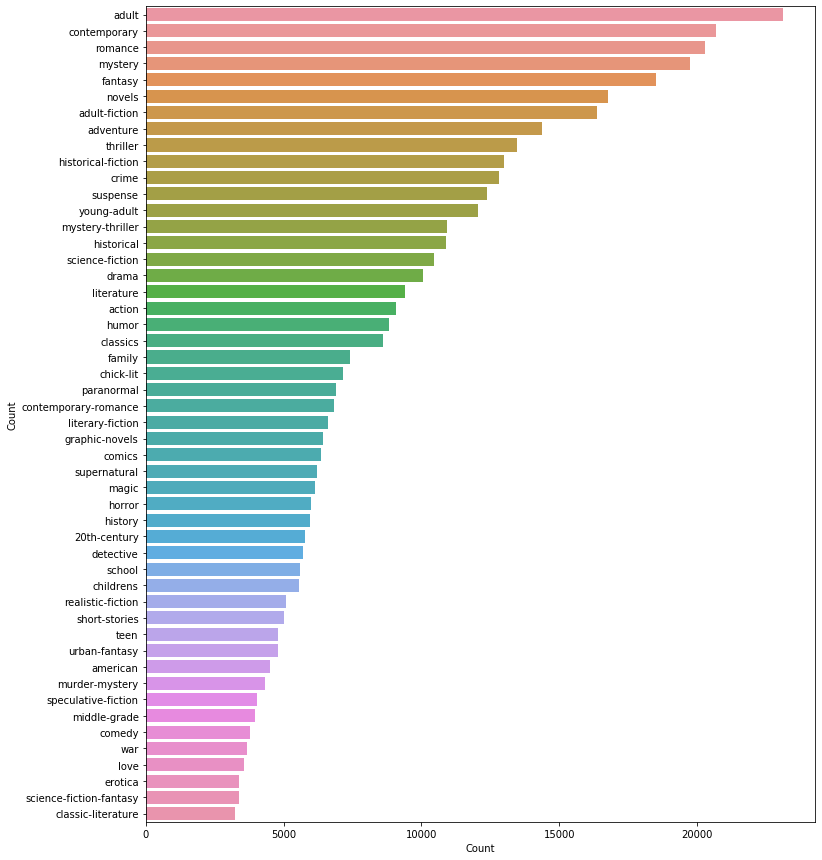

In [7]:
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=top50_genres, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()

### Create train / test genre list based on top 50 genres

In [8]:
# set training data
y_traindf = pd.DataFrame()
y_traindf['genrelist'] = books_train['genrelist']
y_traindf['genrelist_intop50'] = y_traindf['genrelist'].apply(lambda y: [x for x in y if x in unique_genre_list_top50])

y_traindf['genrelist_intop50_top5']=y_traindf['genrelist_intop50'].apply(lambda x: ['' if len(x) < 1 else x[0],
                                                                          '' if len(x) < 2 else x[1],
                                                                          '' if len(x) < 3 else x[2],
                                                                          '' if len(x) < 4 else x[3],
                                                                          '' if len(x) < 5 else x[4]])

y_traindf.head(3)

,genrelist,genrelist_intop50,genrelist_intop50_top5
0,"[young-adult, romance, contemporary, fiction, realistic-fiction, teen, coming-of-age, family, mental-health, illness, love, contemporary-romance, mental-illness, chick-lit, novels, high-school, drama]","[young-adult, romance, contemporary, realistic-fiction, teen, family, love, contemporary-romance, chick-lit, novels, drama]","[young-adult, romance, contemporary, realistic-fiction, teen]"
1,"[classics, fiction, historical-fiction, literature, british-literature, historical, romance, novels, victorian, european-literature, 20th-century, literary-fiction, religion, modern-classics, adult-fiction, 19th-century, english-literature, drama]","[classics, historical-fiction, literature, historical, romance, novels, 20th-century, literary-fiction, adult-fiction, drama]","[classics, historical-fiction, literature, historical, romance]"
2,"[zombies, horror, post-apocalyptic, fiction, science-fiction, apocalyptic, thriller, survival, dystopia, adult, action, fantasy]","[horror, science-fiction, thriller, adult, action, fantasy]","[horror, science-fiction, thriller, adult, action]"


In [9]:
# set testing data
y_testdf = pd.DataFrame() 
y_testdf['genrelist'] = books_test['genrelist']
y_testdf['genrelist_intop50'] = y_testdf['genrelist'].apply(lambda y: [x for x in y if x in unique_genre_list_top50])

y_testdf['genrelist_intop50_top5']=y_testdf['genrelist_intop50'].apply(lambda x: ['' if len(x) < 1 else x[0],
                                                                          '' if len(x) < 2 else x[1],
                                                                          '' if len(x) < 3 else x[2],
                                                                          '' if len(x) < 4 else x[3],
                                                                          '' if len(x) < 5 else x[4]])

y_testdf.head(3)

,genrelist,genrelist_intop50,genrelist_intop50_top5
0,"[science-fiction, fiction, speculative-fiction, science, environment, ecology, science-fiction-fantasy, climate-change, 21st-century, technology, literature]","[science-fiction, speculative-fiction, science-fiction-fantasy, literature]","[science-fiction, speculative-fiction, science-fiction-fantasy, literature, ]"
1,"[fiction, humor, race, contemporary, novels, literary-fiction, african-american, literature, american, comedy, 21st-century, unfinished, politics, adult-fiction, adult, social-justice]","[humor, contemporary, novels, literary-fiction, literature, american, comedy, adult-fiction, adult]","[humor, contemporary, novels, literary-fiction, literature]"
2,"[science-fiction, fiction, science-fiction-fantasy, unfinished, science, space-opera, collections, short-stories]","[science-fiction, science-fiction-fantasy, short-stories]","[science-fiction, science-fiction-fantasy, short-stories, , ]"


### Binarize genre labels

In [10]:
# Append the 2 dataframe together before doing the MultiLabelBinarizer
listtogetbinary = pd.DataFrame()
listtogetbinary['genrelist_intop50_top5'] = y_traindf['genrelist_intop50_top5']
listtogetbinary = listtogetbinary.append(y_testdf[['genrelist_intop50_top5']]).reset_index(drop=True)
print(listtogetbinary.shape)

(60000, 1)


In [11]:
from sklearn.preprocessing import MultiLabelBinarizer
multilabel_binarizer = MultiLabelBinarizer()

y = multilabel_binarizer.fit_transform(listtogetbinary['genrelist_intop50_top5'])
genre_class = multilabel_binarizer.classes_

# delete empty string genre ''
y = np.delete(y, 0, 1)    
genre_class = np.delete(genre_class, 0)

print(y.shape)
print(genre_class.shape)

(60000, 50)
(50,)


In [12]:
train_length = int(topics_train.shape[0])
test_length_start = int(train_length)

train_y_processed = y[:train_length,:]
test_y_processed = y[train_length:,:]

print("Training data shape:", x_train.shape)
print("Training labels shape:", train_y_processed.shape)
print("Testing data shape:", x_test.shape)
print("Testing labels shape:", test_y_processed.shape)

Training data shape: (50000, 2000)
Training labels shape: (50000, 50)
Testing data shape: (10000, 2000)
Testing labels shape: (10000, 50)


## Models

In [13]:
# function to get results from predict_proba matrix
def get_results(prediction_proba):
    df = pd.DataFrame(prediction_proba, columns = genre_class)

    df['top5_pred']=df.apply(lambda x: list(x.nlargest(5).index), axis=1)
    df['top5_actual'] = listtogetbinary['genrelist_intop50_top5'][train_length:].reset_index().drop(columns=['index'])

    df[['top5_pred','top5_actual']]

    df = df[['top5_pred','top5_actual']].copy()
    df['genre_match_count'] = df.apply(lambda x: len(set(x['top5_pred']) & set(x['top5_actual'])), axis=1)

    df['percent_match'] = df.apply(
        lambda x: x['genre_match_count'] / (1 if len(list(filter(lambda y: y != '', x['top5_actual'])))==0 else len(list(filter(lambda y: y != '', x['top5_actual'])))), 
        axis=1)
    
    match_20_per = df[df.percent_match >= 0.2].count()[0] / len(df)
    match_40_per = df[df.percent_match >= 0.4].count()[0] / len(df)
    match_60_per = df[df.percent_match >= 0.6].count()[0] / len(df)
    match_80_per = df[df.percent_match >= 0.8].count()[0] / len(df)
    match_100_per = df[df.percent_match >= 1.0].count()[0] / len(df)

    print("% of books with at least 20% of genre matched:", round(match_20_per*100,2),'%')
    print("% of books with at least 40% of genre matched:",round(match_40_per*100,2),'%')
    print("% of books with at least 60% of genre matched:",round(match_60_per*100,2),'%')
    print("% of books with at least 80% of genre matched:",round(match_80_per*100,2),'%')
    print("% of books with at least 100% of genre matched:",round(match_100_per*100,2),'%')
 
    return df

### F1 metric

In [14]:
from keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Using TensorFlow backend.


### Keras Word Embedding and CNN

In [15]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [16]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]',' ',text) #only keep letters
    return text
    
books_train['description'] = books_train['description'].apply(lambda x: clean_text(x))
books_test['description'] = books_test['description'].apply(lambda x: clean_text(x))

In [17]:
train = books_train['description']
test = books_test['description']

In [18]:
#Fit on text
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(train)

In [19]:
#find max sequence
max_length_train = max([len(a.split()) for a in train])

#vocab size 
vocab_size = len(tokenizer_obj.word_index) + 1

In [20]:
#Tokenize 
x_train_tokens = tokenizer_obj.texts_to_sequences(train)
x_test_tokens = tokenizer_obj.texts_to_sequences(test)

In [21]:
#pad sequence
x_train_pad = pad_sequences(x_train_tokens, maxlen = max_length_train, padding = 'post')
x_test_pad = pad_sequences(x_test_tokens, maxlen = max_length_train, padding = 'post')

In [22]:
print('Train shape:', x_train_pad.shape)
print('Test shape:',x_test_pad.shape)

Train shape: (50000, 940)
Test shape: (10000, 940)


### Pre tuned CNN model

In [23]:
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Input, Dense, Embedding, LSTM, Activation, Flatten
from keras.layers import Conv1D, GlobalMaxPooling1D, Dropout, Concatenate

embedding_dim = 500    # The size of embeddings is 500
input_shape = (max_length_train,)
model_input = Input(shape=input_shape)

# Embedding Layer
z = Embedding(vocab_size, embedding_dim, input_length=max_length_train, name="embedding")(model_input)

# Convolutional Layer 
conv_blocks = []
filter_sizes = [2,3,4]
num_filters = 30

for sz in filter_sizes:
    conv = Conv1D(filters=num_filters,
                  kernel_size=sz,
                  padding="valid",
                  activation="relu",
                  strides=1)(z)
    # Pooling Layer
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)
    
# Fully-connected Layer
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

In [24]:
from keras.models import Model
model_output = Dense(50, activation="sigmoid")(z)
model = Model(model_input, model_output)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[f1])

In [25]:
epochs = 2
hist = model.fit(x_train_pad, train_y_processed, epochs=epochs, validation_split=0.1,verbose=1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/2
45000/45000 [==============================] - 69s 2ms/step - loss: 0.2132 - f1: 0.4181 - val_loss: 0.2042 - val_f1: 0.5008s - loss: 0.2133 - f1: 
Epoch 2/2
45000/45000 [==============================] - 66s 1ms/step - loss: 0.1413 - f1: 0.6720 - val_loss: 0.1997 - val_f1: 0.5322


In [26]:
predictions = model.predict(x_test_pad) 

results_df = get_results(predictions)
results_df

% of books with at least 20% of genre matched: 97.2 %
% of books with at least 40% of genre matched: 87.59 %
% of books with at least 60% of genre matched: 66.8 %
% of books with at least 80% of genre matched: 35.04 %
% of books with at least 100% of genre matched: 11.65 %


,top5_pred,top5_actual,genre_match_count,percent_match
0,"[science-fiction, thriller, adventure, fantasy, war]","[science-fiction, speculative-fiction, science-fiction-fantasy, literature, ]",1,0.250000
1,"[literature, novels, humor, classics, mystery]","[humor, contemporary, novels, literary-fiction, literature]",3,0.600000
2,"[science-fiction, fantasy, adventure, science-fiction-fantasy, novels]","[science-fiction, science-fiction-fantasy, short-stories, , ]",2,0.666667
3,"[romance, mystery, contemporary, adult, suspense]","[historical-fiction, mystery, romance, historical, suspense]",3,0.600000
4,"[mystery, romance, crime, suspense, mystery-thriller]","[mystery, suspense, romance, thriller, contemporary-romance]",3,0.600000
5,"[thriller, suspense, historical-fiction, action, mystery]","[thriller, suspense, contemporary, , ]",2,0.666667
6,"[comics, graphic-novels, science-fiction, humor, action]","[comics, graphic-novels, science-fiction, science-fiction-fantasy, ]",3,0.750000
7,"[science-fiction, fantasy, mystery, adventure, crime]","[science-fiction, fantasy, novels, speculative-fiction, science-fiction-fantasy]",2,0.400000
8,"[adventure, humor, fantasy, novels, science-fiction]","[science-fiction, mystery, fantasy, horror, adult]",2,0.400000
9,"[science-fiction, fantasy, adventure, war, science-fiction-fantasy]","[science-fiction, fantasy, speculative-fiction, adult, adventure]",3,0.600000


In [27]:
# model.save('model_cnn.h5')

## Best Model After Tuning

In [30]:
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Input, Dense, Embedding, LSTM, Activation, Flatten
from keras.layers import Conv1D, GlobalMaxPooling1D, Dropout, Concatenate

embedding_dim = 500    # The size of embeddings is 500
input_shape = (max_length_train,)
model_input = Input(shape=input_shape)

# Embedding Layer
z = Embedding(vocab_size, embedding_dim, input_length=max_length_train, name="embedding")(model_input)

# Convolutional Layer 
conv_blocks = []
filter_sizes = [2,3,4,5,6]
num_filters = 200
for sz in filter_sizes:
    conv = Conv1D(filters=num_filters,
                  kernel_size=sz,
                  padding="valid",
                  activation="relu",
                  strides=1)(z)
    # Pooling Layer
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)
    
# Fully-connected Layer
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

In [31]:
from keras.models import Model
model_output1 = Dense(50, activation="sigmoid")(z)
model1 = Model(model_input, model_output1)
model1.compile(loss="binary_crossentropy", optimizer="Adam", metrics=[f1])

In [32]:
epochs = 3
hist1 = model1.fit(x_train_pad, train_y_processed, epochs=epochs, validation_split=0.1,verbose=1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/3
45000/45000 [==============================] - 197s 4ms/step - loss: 0.1853 - f1: 0.5202 - val_loss: 0.1785 - val_f1: 0.5860
Epoch 2/3
45000/45000 [==============================] - 196s 4ms/step - loss: 0.1101 - f1: 0.7616 - val_loss: 0.1786 - val_f1: 0.6146
Epoch 3/3
45000/45000 [==============================] - 199s 4ms/step - loss: 0.0511 - f1: 0.9058 - val_loss: 0.2251 - val_f1: 0.5915


In [33]:
predictions1 = model1.predict(x_test_pad) 

results_df1 = get_results(predictions1)
results_df1

% of books with at least 20% of genre matched: 98.11 %
% of books with at least 40% of genre matched: 90.41 %
% of books with at least 60% of genre matched: 72.36 %
% of books with at least 80% of genre matched: 42.44 %
% of books with at least 100% of genre matched: 20.37 %


,top5_pred,top5_actual,genre_match_count,percent_match
0,"[science-fiction, speculative-fiction, thriller, adventure, short-stories]","[science-fiction, speculative-fiction, science-fiction-fantasy, literature, ]",2,0.500000
1,"[literature, novels, contemporary, literary-fiction, historical-fiction]","[humor, contemporary, novels, literary-fiction, literature]",4,0.800000
2,"[science-fiction, adventure, fantasy, classics, short-stories]","[science-fiction, science-fiction-fantasy, short-stories, , ]",2,0.666667
3,"[historical-fiction, romance, historical, mystery, contemporary]","[historical-fiction, mystery, romance, historical, suspense]",4,0.800000
4,"[romance, suspense, thriller, mystery, contemporary-romance]","[mystery, suspense, romance, thriller, contemporary-romance]",5,1.000000
5,"[thriller, historical-fiction, suspense, contemporary, romance]","[thriller, suspense, contemporary, , ]",3,1.000000
6,"[science-fiction, comics, fantasy, adult, graphic-novels]","[comics, graphic-novels, science-fiction, science-fiction-fantasy, ]",3,0.750000
7,"[science-fiction, mystery, adventure, fantasy, speculative-fiction]","[science-fiction, fantasy, novels, speculative-fiction, science-fiction-fantasy]",3,0.600000
8,"[classics, novels, adventure, literature, science-fiction]","[science-fiction, mystery, fantasy, horror, adult]",1,0.200000
9,"[science-fiction, adult, speculative-fiction, fantasy, novels]","[science-fiction, fantasy, speculative-fiction, adult, adventure]",4,0.800000


In [34]:
model1.save('model_cnn_tunned.h5')
results_df1.to_csv('cnn_tunned_results_df.csv')

In [ ]:
# from keras.models import load_model
# new_model = load_model('./Models_results/cnn_model/model_cnn_tunned.h5', custom_objects={'f1':f1})

### Recall of genre prediction

In [31]:
def matched(list1,list2):
    results = {}
    for i in list1:
        results[i] = list2.count(i) 
    
    return results

# Get matched genres for each row
results_df1['matched'] = results_df1.apply(lambda row: matched(row['top5_pred'],row['top5_actual']), axis =1)

In [263]:
results_df1.head(5)

,top5_pred,top5_actual,genre_match_count,percent_match,matched
0,"[science-fiction, speculative-fiction, thriller, adventure, short-stories]","[science-fiction, speculative-fiction, science-fiction-fantasy, literature, ]",2,0.500000,"{'science-fiction': 1, 'speculative-fiction': 1, 'thriller': 0, 'adventure': 0, 'short-stories': 0}"
1,"[literature, novels, contemporary, literary-fiction, historical-fiction]","[humor, contemporary, novels, literary-fiction, literature]",4,0.800000,"{'literature': 1, 'novels': 1, 'contemporary': 1, 'literary-fiction': 1, 'historical-fiction': 0}"
2,"[science-fiction, adventure, fantasy, classics, short-stories]","[science-fiction, science-fiction-fantasy, short-stories, , ]",2,0.666667,"{'science-fiction': 1, 'adventure': 0, 'fantasy': 0, 'classics': 0, 'short-stories': 1}"
3,"[historical-fiction, romance, historical, mystery, contemporary]","[historical-fiction, mystery, romance, historical, suspense]",4,0.800000,"{'historical-fiction': 1, 'romance': 1, 'historical': 1, 'mystery': 1, 'contemporary': 0}"
4,"[romance, suspense, thriller, mystery, contemporary-romance]","[mystery, suspense, romance, thriller, contemporary-romance]",5,1.000000,"{'romance': 1, 'suspense': 1, 'thriller': 1, 'mystery': 1, 'contemporary-romance': 1}"


In [202]:
# Sum the number of times each genre was matched
matched_genre = {} 
for d in results_df1['matched']: 
    for k in d.keys(): 
        matched_genre[k] = matched_genre.get(k, 0) + d[k] 
  
  
matched_genre_df = pd.DataFrame(matched_genre.items(), columns=['genre', 'count'])

# Count the frequency of each actual genre in the test data
test_genre_freq = {} 
for i in range(len(results_df1)) : 
    for j in results_df1.loc[i, 'top5_actual']:
        test_genre_freq[j] = test_genre_freq.get(j, 0) + 1
      
  
test_genre_freq_df = pd.DataFrame(test_genre_freq.items(), columns=['genre', 'count'])
test_genre_freq_df = test_genre_freq_df[test_genre_freq_df.genre != ''].reset_index().drop(['index'], axis=1)

In [203]:
# Merge the 2 dataframes and compute the % matched for each genre
merge_df = test_genre_freq_df.merge(matched_genre_df, left_on='genre', right_on='genre')
merge_df = merge_df.merge(top50_genres, left_on='genre', right_on='Genre').drop(['Genre'], axis=1)

merge_df.columns = ['genre','test_actual_freq','matched_freq','train_actual_freq']
merge_df['perc_matched'] = merge_df['matched_freq'] / merge_df['test_actual_freq']
merge_df.sort_values(by=['perc_matched'], inplace=True, ascending=False)

In [226]:
merge_df.head(5)

,genre,test_actual_freq,matched_freq,train_actual_freq,perc_matched
11,romance,4025,3559,20291,0.884224
9,historical-fiction,2839,2481,12988,0.873899
12,historical,2137,1753,10890,0.820309
0,science-fiction,2553,2059,10471,0.806502
5,contemporary,2143,1664,20706,0.776482


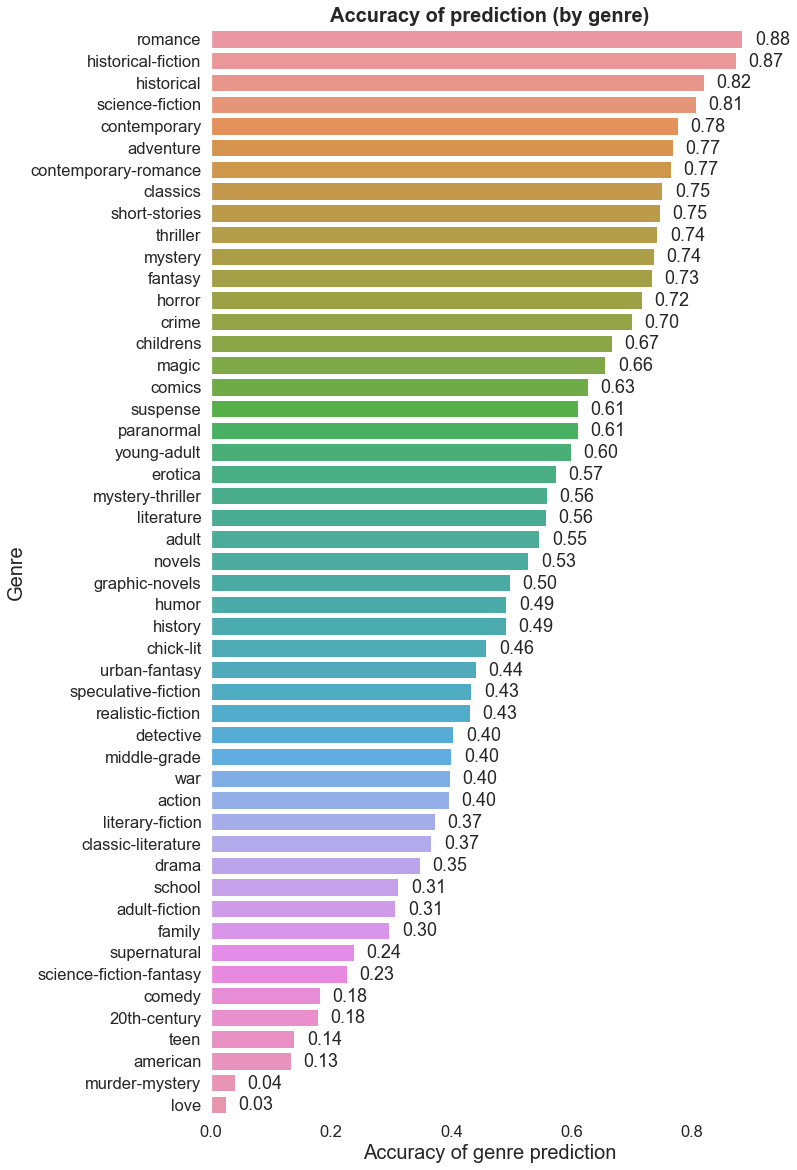

In [243]:
plt.figure(figsize=(10,20)) 
sns.set(font_scale=1.5)
ax = sns.barplot(data=merge_df, x= "perc_matched", y = "genre") 

# for index, row in merge_df.iterrows():
#     ax.text(row.name,row.perc_matched, round(row.perc_matched,2), color='black', ha="center")

for p in ax.patches:
    width = p.get_width()
    plt.text(0.05+p.get_width(), p.get_y()+0.55*p.get_height(),
             '{:1.2f}'.format(width),
             ha='center', va='center')

plt.title('Accuracy of prediction (by genre)', fontsize=20, fontweight='bold')
plt.xlabel('Accuracy of genre prediction', fontsize=20)
plt.ylabel('Genre', fontsize=20)
ax.set_facecolor('w')
    
plt.show()

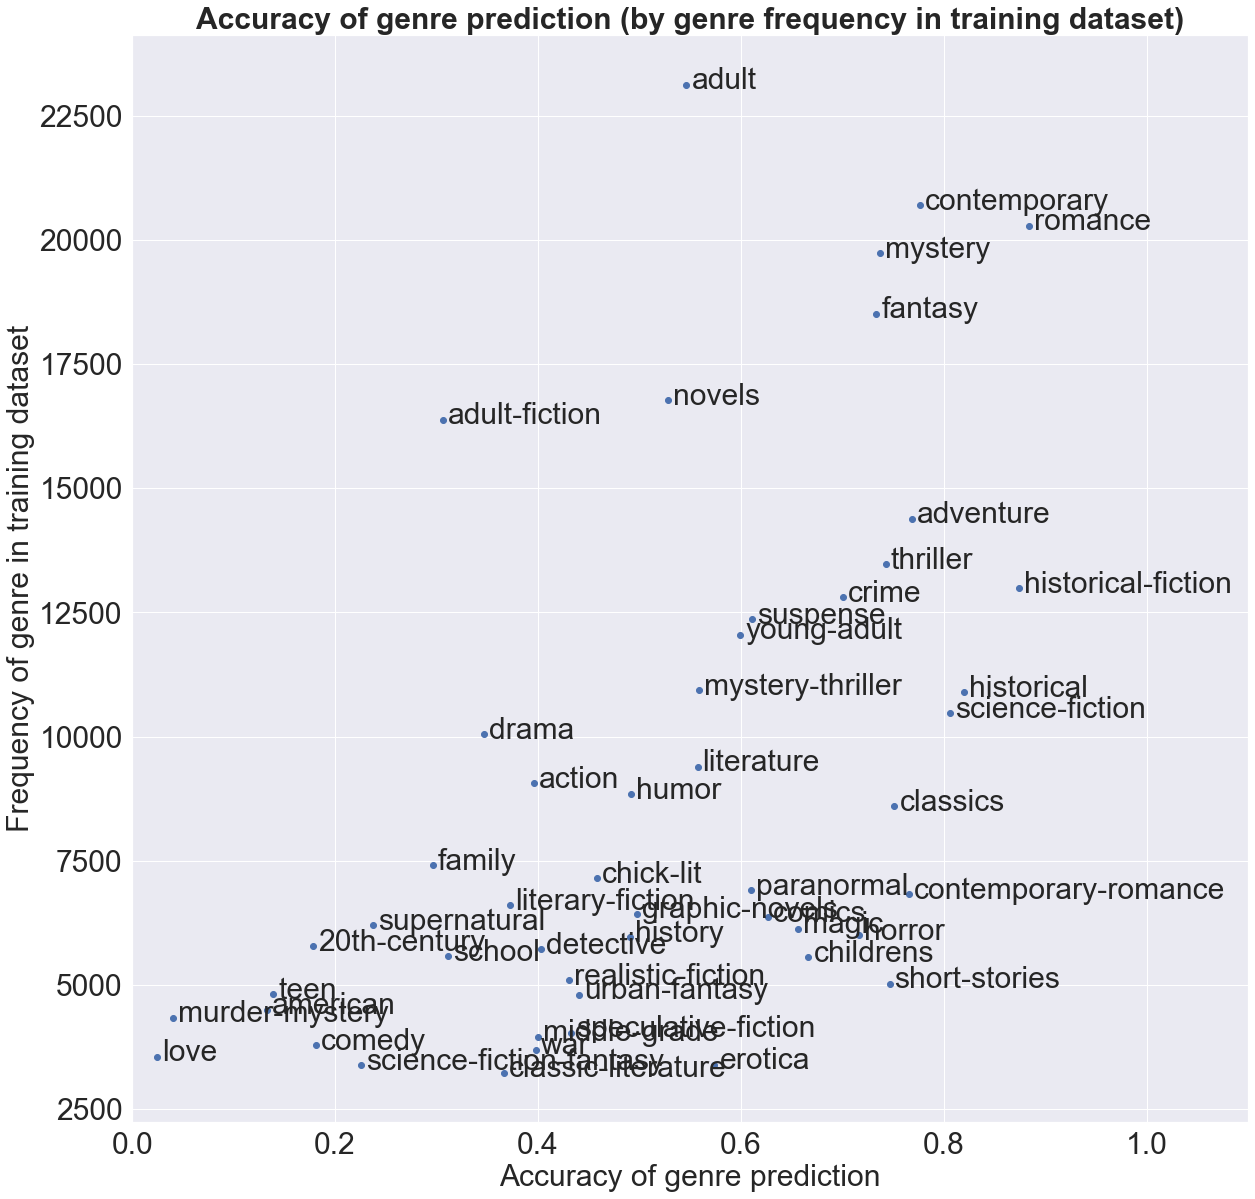

In [260]:
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(merge_df['perc_matched'], merge_df['train_actual_freq'])

for i, label in enumerate(merge_df['genre']):
    ax.text(merge_df['perc_matched'][i]+0.005, merge_df['train_actual_freq'][i]-90, merge_df['genre'][i], fontsize=30)
    
plt.title('Accuracy of genre prediction (by genre frequency in training dataset)', fontsize=30, fontweight='bold')
plt.xlabel('Accuracy of genre prediction', fontsize=30)
plt.ylabel('Frequency of genre in training dataset', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
ax.set_xlim([0,1.1])

plt.show()

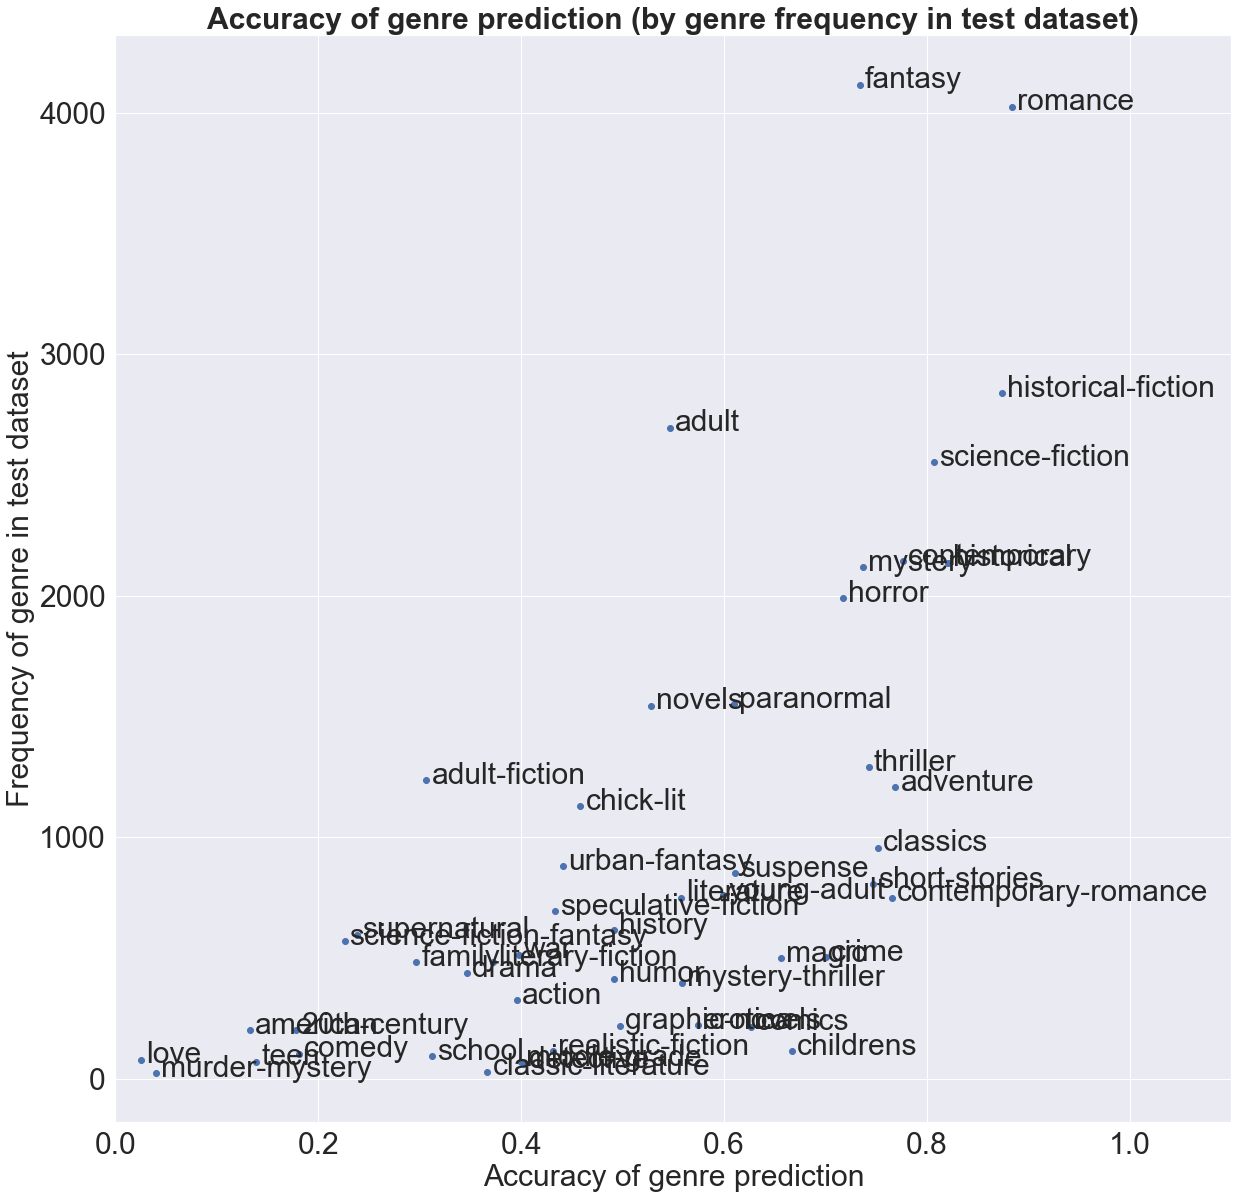

In [261]:
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(merge_df['perc_matched'], merge_df['test_actual_freq'])

for i, label in enumerate(merge_df['genre']):
    ax.text(merge_df['perc_matched'][i]+0.005, merge_df['test_actual_freq'][i]-15, merge_df['genre'][i], fontsize=30)
    
plt.title('Accuracy of genre prediction (by genre frequency in test dataset)', fontsize=30, fontweight='bold')
plt.xlabel('Accuracy of genre prediction', fontsize=30)
plt.ylabel('Frequency of genre in test dataset', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
ax.set_xlim([0,1.1])

plt.show()